In [3]:
# Autoreload 
%load_ext autoreload
%autoreload 2

from pathlib import Path 
import pandas as pd 
import numpy as np
import os 
import re 
import gzip 
import shutil
import Bio.PDB.MMCIF2Dict
from typing import Union, List, Tuple, Dict, Optional
from pathlib import Path
from tqdm import tqdm

pd.options.mode.chained_assignment = None  # default='warn'

from phosphosite.utils import aa1to3, aa3to1

from phosphosite.domain import map_site_to_domain, download_uniprot_data
from phosphosite import UNIPROT_DATA_DIR 
UNIPROT_DATA_DIR.is_dir()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
result_path = Path("./results/bubbles.h5")

## Load results
result_df = pd.read_hdf(result_path, key="data")
len(result_df.protein_id.unique())

494

In [5]:
result_path = Path("./results/all_bubbles.h5")

## Load results
result_df = pd.read_hdf(result_path, key="data")
len(result_df.protein_id.unique())

17336

In [6]:
# Load uniprot_ids 
with open("./uniprot_ids.txt") as f:
    uniprot_ids = f.read().splitlines()


In [7]:
len(uniprot_ids)

17336

In [8]:
# Last 100 
uniprot_ids[-100:]

['Q9Y693',
 'Q9Y694',
 'Q9Y696',
 'Q9Y697',
 'Q9Y698',
 'Q9Y6A1',
 'Q9Y6A2',
 'Q9Y6A4',
 'Q9Y6A5',
 'Q9Y6A9',
 'Q9Y6B2',
 'Q9Y6B6',
 'Q9Y6B7',
 'Q9Y6C2',
 'Q9Y6C5',
 'Q9Y6C9',
 'Q9Y6D5',
 'Q9Y6D6',
 'Q9Y6D9',
 'Q9Y6E0',
 'Q9Y6E2',
 'Q9Y6E7',
 'Q9Y6F1',
 'Q9Y6F6',
 'Q9Y6F7',
 'Q9Y6F8',
 'Q9Y6F9',
 'Q9Y6G1',
 'Q9Y6G3',
 'Q9Y6G5',
 'Q9Y6G9',
 'Q9Y6H1',
 'Q9Y6H3',
 'Q9Y6H5',
 'Q9Y6H6',
 'Q9Y6H8',
 'Q9Y6I3',
 'Q9Y6I4',
 'Q9Y6I7',
 'Q9Y6I9',
 'Q9Y6J0',
 'Q9Y6J8',
 'Q9Y6J9',
 'Q9Y6K0',
 'Q9Y6K1',
 'Q9Y6K5',
 'Q9Y6K8',
 'Q9Y6K9',
 'Q9Y6L6',
 'Q9Y6L7',
 'Q9Y6M0',
 'Q9Y6M1',
 'Q9Y6M4',
 'Q9Y6M5',
 'Q9Y6M7',
 'Q9Y6M9',
 'Q9Y6N1',
 'Q9Y6N3',
 'Q9Y6N5',
 'Q9Y6N6',
 'Q9Y6N7',
 'Q9Y6N8',
 'Q9Y6N9',
 'Q9Y6P5',
 'Q9Y6Q1',
 'Q9Y6Q2',
 'Q9Y6Q3',
 'Q9Y6Q5',
 'Q9Y6Q6',
 'Q9Y6Q9',
 'Q9Y6R0',
 'Q9Y6R1',
 'Q9Y6R4',
 'Q9Y6R6',
 'Q9Y6R7',
 'Q9Y6R9',
 'Q9Y6S9',
 'Q9Y6T7',
 'Q9Y6U3',
 'Q9Y6U7',
 'Q9Y6V0',
 'Q9Y6V7',
 'Q9Y6W3',
 'Q9Y6W5',
 'Q9Y6W6',
 'Q9Y6W8',
 'Q9Y6X0',
 'Q9Y6X1',
 'Q9Y6X2',
 'Q9Y6X3',
 'Q9Y6X4',

In [9]:
len(result_df["protein_id"].unique())

17336

#### Annotate known phosphorylation sites from PhosphoSitePlus dataset

In [10]:
from phosphosite.dataset.psp import phosphorylation
phosphorylation

%timeit phosphorylation

22 ns ± 1.57 ns per loop (mean ± std. dev. of 7 runs, 10,000,000 loops each)


In [11]:
df = phosphorylation[["ACC_ID", "MOD_RSD"]].drop_duplicates()
df.rename(columns={"ACC_ID": "protein_id"}, inplace=True)

# Get separate columns for residue and position


In [12]:
df["modification"] = df["MOD_RSD"].str.split("-").str[1]
df["res"] = df["MOD_RSD"].str.split("-").str[0].str[0]
df["pos"] = df["MOD_RSD"].str.split("-").str[0].str[1:].astype(int)
df = df[["protein_id", "res", "pos", "modification"]]
df

,protein_id,res,pos,modification
0,Q8R3W2,S,119,p
1,Q9CTA4,S,10,p
2,Q9CTA4,T,11,p
3,P31946,T,2,p
4,Q9CQV8,T,2,p
...,...,...,...,...
378766,Q8IYH5,S,606,p
378767,Q6KAQ7,S,613,p
378768,Q8IYH5,Y,670,p
378769,Q8IYH5,S,677,p


In [13]:
result_df

,protein_id,prev,res,pos,next,ref_atom,ref_atom_dist,nn_res,nn_pos,nn_atom,site_qual,site_structure,nn_qual,nn_structure
0,A0A075B759,N,S,4,V,CA,4.805941,Q,163,NE2,93.22,unstructured,96.92,STRN
1,A0A075B759,N,S,4,V,OG,3.702720,Q,163,NE2,93.22,unstructured,96.92,STRN
0,A0A075B759,I,S,21,I,CA,3.452576,V,6,O,98.17,STRN,98.44,STRN
1,A0A075B759,I,S,21,I,OG,2.965607,E,134,OE2,98.17,STRN,96.86,STRN
0,A0A075B759,L,S,40,T,CA,3.415834,R,37,O,98.29,HELX_RH_AL_P,98.22,HELX_RH_AL_P
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,Q9HAU8,M,Y,633,T,OH,2.951282,E,600,OE1,90.56,HELX_RH_AL_P,92.90,HELX_RH_AL_P
0,Q9HAU8,L,Y,638,E,CA,3.649874,I,635,O,95.74,HELX_RH_AL_P,92.39,HELX_RH_AL_P
1,Q9HAU8,L,Y,638,E,OH,3.348084,F,654,CA,95.74,HELX_RH_AL_P,96.85,HELX_RH_AL_P
0,Q9HAU8,F,Y,655,Q,CA,3.484021,Q,658,NE2,96.43,HELX_RH_AL_P,92.47,HELX_RH_3T_P


In [14]:
df

,protein_id,res,pos,modification
0,Q8R3W2,S,119,p
1,Q9CTA4,S,10,p
2,Q9CTA4,T,11,p
3,P31946,T,2,p
4,Q9CQV8,T,2,p
...,...,...,...,...
378766,Q8IYH5,S,606,p
378767,Q6KAQ7,S,613,p
378768,Q8IYH5,Y,670,p
378769,Q8IYH5,S,677,p


In [15]:
phos_series = result_df.merge(df, on=["protein_id", "res", "pos"], how="left").modification.notna()#.astype(int)
result_df["phos"] = phos_series.values

In [16]:
result_df

,protein_id,prev,res,pos,next,ref_atom,ref_atom_dist,nn_res,nn_pos,nn_atom,site_qual,site_structure,nn_qual,nn_structure,phos
0,A0A075B759,N,S,4,V,CA,4.805941,Q,163,NE2,93.22,unstructured,96.92,STRN,False
1,A0A075B759,N,S,4,V,OG,3.702720,Q,163,NE2,93.22,unstructured,96.92,STRN,False
0,A0A075B759,I,S,21,I,CA,3.452576,V,6,O,98.17,STRN,98.44,STRN,False
1,A0A075B759,I,S,21,I,OG,2.965607,E,134,OE2,98.17,STRN,96.86,STRN,False
0,A0A075B759,L,S,40,T,CA,3.415834,R,37,O,98.29,HELX_RH_AL_P,98.22,HELX_RH_AL_P,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,Q9HAU8,M,Y,633,T,OH,2.951282,E,600,OE1,90.56,HELX_RH_AL_P,92.90,HELX_RH_AL_P,False
0,Q9HAU8,L,Y,638,E,CA,3.649874,I,635,O,95.74,HELX_RH_AL_P,92.39,HELX_RH_AL_P,False
1,Q9HAU8,L,Y,638,E,OH,3.348084,F,654,CA,95.74,HELX_RH_AL_P,96.85,HELX_RH_AL_P,False
0,Q9HAU8,F,Y,655,Q,CA,3.484021,Q,658,NE2,96.43,HELX_RH_AL_P,92.47,HELX_RH_3T_P,False


In [158]:
from phosphosite.domain import get_proteins_from_motif

[autoreload of phosphosite.domain failed: Traceback (most recent call last):
  File "/home/cim/anaconda3/envs/phosphosite/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 273, in check
    superreload(m, reload, self.old_objects)
  File "/home/cim/anaconda3/envs/phosphosite/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 471, in superreload
    module = reload(module)
  File "/home/cim/anaconda3/envs/phosphosite/lib/python3.9/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 613, in _exec
  File "<frozen importlib._bootstrap_external>", line 846, in exec_module
  File "<frozen importlib._bootstrap_external>", line 983, in get_code
  File "<frozen importlib._bootstrap_external>", line 913, in source_to_code
  File "<frozen importlib._bootstrap>", line 228, in _call_with_frames_removed
  File "/home/cim/STRUCTURAL_MOTIFS/phosphosite/phosphosite/domain/__init__.py", line 100
  

ImportError: cannot import name 'get_proteins_from_motif' from 'phosphosite.domain' (/home/cim/STRUCTURAL_MOTIFS/phosphosite/phosphosite/domain/__init__.py)

In [227]:
from phosphosite import GAMMA_OXYGEN_CODES

def get_proteins_from_motif(
    df: pd.DataFrame,
    triplet: str, 
    nn: str, 
    ref_atom: str = None,
    phosphosite: bool = None,
) -> List[str]:
    """Return the list of proteins that contain a given motif."""
    
    # Filter by ref_atom
    if ref_atom is not None:
        if ref_atom == "CA": ref_atom = ["CA"]
        elif ref_atom == "oxygen": ref_atom = GAMMA_OXYGEN_CODES
        df = df[df["ref_atom"].isin(ref_atom)]
    
    # Turn dataframe cols into just residue (i.e. first character)
    for col in ["prev", "res", "next", "nn_res"]:
        df[col] = df[col].str[0] 

    # If "next" is unspecified: 
    #if len(triplet) == 2:
    #    df = df[(df["prev"] == triplet[0]) & (df["res"] == triplet[1]) & (df["nn_pos"] == nn)]
    #else:
    #    df = df[(df["prev"] == triplet[0]) & (df["res"] == triplet[1]) & (df["next"] == triplet[2]) & (df["nn_pos"] == nn)]
    
    # Filter by phosphosite
    if phosphosite is not None:
        df = df[df["phos"] == phosphosite]

    return df[(df.prev == triplet[0]) & 
              (df.res == triplet[1]) & 
              (df.next == triplet[2]) & 
              (df.nn_res == nn)].protein_id.unique().tolist()

def get_sites_from_motif(
    df: pd.DataFrame,
    triplet: str, 
    nn: str, 
    ref_atom: str = None,
    phosphosite: bool = None,
) -> List[str]:
    """Return the list of sites (protein id, site) that contain a given motif."""
    
    # Filter by ref_atom
    if ref_atom is not None:
        if ref_atom == "CA": ref_atom = ["CA"]
        elif ref_atom == "oxygen": ref_atom = GAMMA_OXYGEN_CODES
        df = df[df["ref_atom"].isin(ref_atom)]
    
    # Turn dataframe cols into just residue (i.e. first character)
    for col in ["prev", "res", "next", "nn_res"]:
        df[col] = df[col].str[0] 

    # If "next" is unspecified: 
    #if len(triplet) == 2:
    #    df = df[(df["prev"] == triplet[0]) & (df["res"] == triplet[1]) & (df["nn_pos"] == nn)]
    #else:
    #    df = df[(df["prev"] == triplet[0]) & (df["res"] == triplet[1]) & (df["next"] == triplet[2]) & (df["nn_pos"] == nn)]
    
    # Filter by phosphosite
    if phosphosite is not None:
        df = df[df["phos"] == phosphosite]

    dff = df[(df.prev == triplet[0]) & 
              (df.res == triplet[1]) & 
              (df.next == triplet[2]) & 
              (df.nn_res == nn)]

    dff = dff[["protein_id", "res", "pos"]]
    
    # Return list of tuples (protein_id, res, pos)
    return list(dff.itertuples(index=False, name=None))



### Zinc Finger domain signal (Tyrosine)

Gamma-oxygen: PYE-R and PYK-R 

Alpha-carbon: PYE-F and PYK-F


In [117]:
# Zinc Finger -- gamma oxygen 
triplet, nn, phosphosite, ref_atom = "PYK", "R", True, "oxygen"  # 784 / 40    background/phosphosite split
triplet, nn, phosphosite, ref_atom = "PYE", "R", True, None # Get all 

# Unknown tyrosine signals 
triplet, nn, phosphosite, ref_atom = "RYL", "E", True, None
triplet, nn, phosphosite, ref_atom = "SYL", "L", True, None

phos    = get_proteins_from_motif(result_df, triplet, nn, phosphosite=phosphosite, ref_atom=ref_atom)
notphos = get_proteins_from_motif(result_df, triplet, nn, phosphosite=not phosphosite, ref_atom=ref_atom)

all_prots = list(set(phos + notphos))



# Write uniprot ids to file
with open("uniprot_kb.txt", "w") as f:
    for prot in all_prots:
        f.write(prot + "\n")

# Ensure all entries are downloaded 
download_uniprot_data(all_prots)

626
1019


KeyboardInterrupt: 

### Tyrosine signal RYL-E (207 / 42)


In [133]:
triplet, nn, phosphosite, ref_atom = "RYL", "E", True, "oxygen"
phos_motif = get_proteins_from_motif(result_df, triplet, nn, phosphosite=phosphosite, ref_atom=ref_atom)
non_motif = get_proteins_from_motif(result_df, triplet, nn, phosphosite=not phosphosite, ref_atom=ref_atom)

triplet, nn, phosphosite, ref_atom = "PYE", "R", True, "oxygen"
phos_motif = get_proteins_from_motif(result_df, triplet, nn, phosphosite=phosphosite, ref_atom=ref_atom)
non_motif = get_proteins_from_motif(result_df, triplet, nn, phosphosite=not phosphosite, ref_atom=ref_atom)

znf_phos_sites = get_sites_from_motif(result_df, triplet, nn, phosphosite=True, ref_atom=ref_atom)
znf_notphos_sites = get_sites_from_motif(result_df, triplet, nn, phosphosite=False, ref_atom=ref_atom)

triplet, nn, phosphosite, ref_atom = "PYK", "R", True, "oxygen"

znfk_phos_sites = get_sites_from_motif(result_df, triplet, nn, phosphosite=True, ref_atom=ref_atom)
znfk_notphos_sites = get_sites_from_motif(result_df, triplet, nn, phosphosite=False, ref_atom=ref_atom)


In [203]:
ryl_phos_sites = get_sites_from_motif(result_df, triplet, nn, phosphosite=True, ref_atom=ref_atom)
ryl_notphos_sites = get_sites_from_motif(result_df, triplet, nn, phosphosite=False, ref_atom=ref_atom)

In [123]:
print(len(ryl_phos_sites))
len(list(set([i[0] for i in ryl_phos_sites]))) # Unique protein ids

42


42

In [122]:
ryl_phos_sites

[('A5YKK6', 'Y', 2264),
 ('A6NDG6', 'Y', 187),
 ('A6NFN9', 'Y', 46),
 ('O14544', 'Y', 416),
 ('O14964', 'Y', 329),
 ('O15013', 'Y', 640),
 ('O96014', 'Y', 241),
 ('P00338', 'Y', 172),
 ('P07195', 'Y', 173),
 ('P09172', 'Y', 327),
 ('P09601', 'Y', 137),
 ('P21860', 'Y', 680),
 ('P35580', 'Y', 13),
 ('P52888', 'Y', 141),
 ('P55265', 'Y', 722),
 ('P58753', 'Y', 216),
 ('P62258', 'Y', 131),
 ('Q13459', 'Y', 1300),
 ('Q16526', 'Y', 432),
 ('Q16658', 'Y', 69),
 ('Q29983', 'Y', 194),
 ('Q49AN0', 'Y', 451),
 ('Q5VVJ2', 'Y', 409),
 ('Q6P995', 'Y', 514),
 ('Q6UVK1', 'Y', 743),
 ('Q9UKK3', 'Y', 959),
 ('Q9UH17', 'Y', 191),
 ('Q8TC27', 'Y', 285),
 ('Q9Y6V7', 'Y', 223),
 ('Q9UNS1', 'Y', 41),
 ('Q9H4L7', 'Y', 897),
 ('Q8IWA5', 'Y', 120),
 ('Q9NP66', 'Y', 152),
 ('Q96M96', 'Y', 443),
 ('Q8WUR7', 'Y', 106),
 ('Q9Y6A2', 'Y', 341),
 ('Q8N1D5', 'Y', 93),
 ('Q8N960', 'Y', 884),
 ('Q9Y6M0', 'Y', 130),
 ('Q9NT99', 'Y', 211),
 ('Q9GZT6', 'Y', 234),
 ('Q9UPR0', 'Y', 248)]

In [48]:
all_ids = list(set([i[0] for i in ryl_phos_sites]) | set([i[0] for i in ryl_notphos_sites]))
len(all_ids)

204

In [204]:
[i[0] for i in ryl_phos_sites]

['A5YKK6',
 'A6NDG6',
 'A6NFN9',
 'O14544',
 'O14964',
 'O15013',
 'O96014',
 'P00338',
 'P07195',
 'P09172',
 'P09601',
 'P21860',
 'P35580',
 'P52888',
 'P55265',
 'P58753',
 'P62258',
 'Q13459',
 'Q16526',
 'Q16658',
 'Q29983',
 'Q49AN0',
 'Q5VVJ2',
 'Q6P995',
 'Q6UVK1',
 'Q9UKK3',
 'Q9UH17',
 'Q8TC27',
 'Q9Y6V7',
 'Q9UNS1',
 'Q9H4L7',
 'Q8IWA5',
 'Q9NP66',
 'Q96M96',
 'Q8WUR7',
 'Q9Y6A2',
 'Q8N1D5',
 'Q8N960',
 'Q9Y6M0',
 'Q9NT99',
 'Q9GZT6',
 'Q9UPR0']

In [251]:
def count_domains(sites: List[Tuple[str, str, int]], condition: str = None) -> Dict[str, int]:
    """Count the number of sites in each domain."""
    counts = {}

    rows = []
    for site in sites:
        protein_id, res, pos = site
        domain = map_site_to_domain(protein_id=protein_id, pos=pos, multiple=False)

        for feature in ["ZN_FING", "COILED", "DNA_BIND"]:
            if feature in domain:
                rows.append(dict(other=feature, condition=condition))
        
        
        domain["condition"] = condition

        #print(domain)
        #continue
        rows.append(domain)
        continue 
        if domain not in counts:
            counts[domain] = 1
        else:
            counts[domain] += 1
    

    # Turn into a dataframe using rows of dicts 

    count_df = pd.DataFrame(rows)
    #count_df = count_df.sort_values(by="count", ascending=False)
    #count_df = count_df.reset_index().rename(columns={"index": "domain"})
    return count_df

df1 = count_domains(ryl_phos_sites, condition="Phosphorylated")
df2 = count_domains(ryl_notphos_sites, condition="Unmodified")

ryl_df = pd.concat([df1, df2])

# Replace all None in "domain" with "Not annotated"
ryl_df["domain"] = ryl_df["domain"].fillna("Not annotated")
ryl_df.condition.unique()

array(['Phosphorylated', 'Unmodified'], dtype=object)

In [253]:
ryl_df.other.unique()

array([nan, 'DNA_BIND', 'COILED', 'ZN_FING'], dtype=object)

In [259]:
import matplotlib.pyplot as plt

def plot_bar_chart(
    df: pd.DataFrame,
    x_var: str,
    y_var: str,
):


    df_grouped = df.groupby(x_var)[y_var].value_counts(normalize=True).unstack(y_var)
    df_grouped.plot.barh(stacked=True)
    plt.legend(
        bbox_to_anchor=(0.5, 1.02),
        loc="lower center",
        borderaxespad=0,
        frameon=False,
        ncol=3,
    )
    for ix, row in df_grouped.reset_index(drop=True).iterrows():
        print(ix, row)
        cumulative = 0
        for element in row:
            if element == element and element > 0.1:
                plt.text(
                    cumulative + element / 2,
                    ix,
                    f"{int(element * 100)} %",
                    va="center",
                    ha="center",
                )
            cumulative += element
    plt.tight_layout()

In [255]:
def make_plot(
        triplet, 
        nn, 
        phosphosite,
        ref_atom,

        y_var: str = None
):

    

    phos_sites = get_sites_from_motif(result_df, triplet, nn, phosphosite=True, ref_atom=ref_atom)
    notphos_sites = get_sites_from_motif(result_df, triplet, nn, phosphosite=False, ref_atom=ref_atom)
    
    df1 = count_domains(phos_sites, condition="Phosphorylated")
    df2 = count_domains(notphos_sites, condition="Unmodified")

    df = pd.concat([df1, df2])

    # Replace all None in "domain" with "Not annotated"
    df["domain"] = df["domain"].fillna("Not annotated")
    df.condition.unique()

    plot_bar_chart(df, x_var="condition", y_var=y_var)



In [257]:
triplet, nn, phosphosite, ref_atom = "PYK", "F", True, "CA"
y_var = "domain"
make_plot(triplet, nn, True, ref_atom, y_var=y_var)
#make_plot(triplet, nn, False, ref_atom, y_var=y_var)


StopIteration: 

In [247]:
# Drop "domain"
dff = df.drop("domain", axis=1)

# Turn NaN into 0 and True into 1
dff = dff.fillna(0)
dff

,condition,dna_bind,coiled,zn_fing
0,Phosphorylated,0,0,0
1,Phosphorylated,0,0,0
2,Phosphorylated,0,0,0
3,Phosphorylated,0,0,0
4,Phosphorylated,0,0,0
...,...,...,...,...
160,Unmodified,0,0,0
161,Unmodified,0,0,0
162,Unmodified,0,0,0
163,Unmodified,0,0,0


In [248]:
# Create new column for whether structure is "dna_bind", "coiled" or "zn_fing"
# Turn the existing columns into a "motif" column (use name of the column as the value if it is not 0)

dff = 

In [ ]:
triplet, nn, phosphosite, ref_atom = "PYE", "F", True, "CA"


In [289]:
triplet, nn, phosphosite, ref_atom = "RYL", "E", True, "oxygen"

phos_sites = get_sites_from_motif(result_df, triplet, nn, phosphosite=True, ref_atom=ref_atom)
notphos_sites = get_sites_from_motif(result_df, triplet, nn, phosphosite=False, ref_atom=ref_atom)

df1 = count_domains(phos_sites, condition="Phosphorylated")
df2 = count_domains(notphos_sites, condition="Unmodified")

df = pd.concat([df1, df2])

# Fill NaN with "Not annotated"
df["domain"] = df["domain"].fillna("Not annotated")

ryl_e = df 



In [291]:
ryl_e.other.value_counts()

DNA_BIND    3
COILED      3
ZN_FING     3
Name: other, dtype: int64

In [292]:
9 / 216

0.041666666666666664

In [281]:
triplet, nn, phosphosite, ref_atom = "PYE", "R", True, "oxygen"

phos_sites = get_sites_from_motif(result_df, triplet, nn, phosphosite=True, ref_atom=ref_atom)
notphos_sites = get_sites_from_motif(result_df, triplet, nn, phosphosite=False, ref_atom=ref_atom)

df1 = count_domains(phos_sites, condition="Phosphorylated")
df2 = count_domains(notphos_sites, condition="Unmodified")

df = pd.concat([df1, df2])

# Fill NaN with "Not annotated"
df["domain"] = df["domain"].fillna("Not annotated")

#df["other"] = df["other"].fillna("Not annotated")

pye_r = df



In [286]:
pye_f = df
pye_f.other.value_counts()

ZN_FING    698
Name: other, dtype: int64

In [288]:
rye

,other,condition,ZN_FING,domain
0,ZN_FING,Phosphorylated,NaN,Not annotated
1,NaN,Phosphorylated,True,Not annotated
2,ZN_FING,Phosphorylated,NaN,Not annotated
3,NaN,Phosphorylated,True,Not annotated
4,NaN,Phosphorylated,NaN,Tyrosine-protein phosphatase 2
...,...,...,...,...
1386,NaN,Unmodified,True,Not annotated
1387,ZN_FING,Unmodified,NaN,Not annotated
1388,NaN,Unmodified,True,Not annotated
1389,ZN_FING,Unmodified,NaN,Not annotated


In [287]:
698 / 1456

0.4793956043956044

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


0 domain
Cadherin 6                             NaN
Chromo 2                               NaN
Ephrin RBD                             NaN
GST C-terminal                         NaN
HECT                                   NaN
N-terminal Ras-GEF                0.015385
Not annotated                     0.938462
PH                                     NaN
RBD                                    NaN
RHD                                    NaN
RRM                                    NaN
Rhodanese 1                            NaN
Tyrosine-protein phosphatase 2    0.046154
Name: 0, dtype: float64
1 domain
Cadherin 6                        0.000719
Chromo 2                          0.000719
Ephrin RBD                        0.000719
GST C-terminal                    0.000719
HECT                              0.000719
N-terminal Ras-GEF                     NaN
Not annotated                     0.992092
PH                                0.000719
RBD                               0.000719
RHD         

posx and posy should be finite values
posx and posy should be finite values


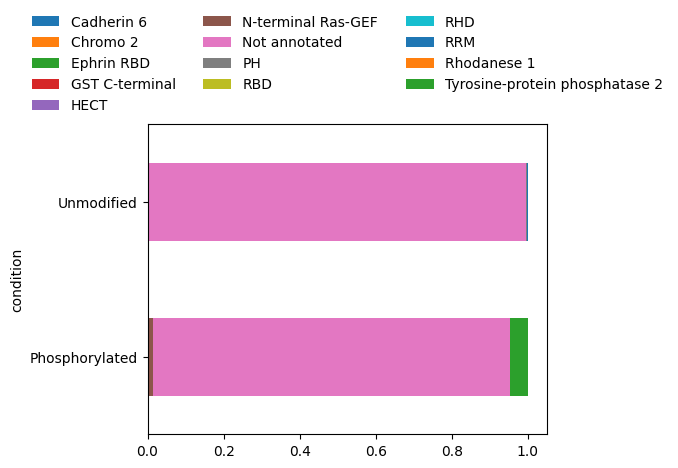

In [279]:
plot_bar_chart(df=pye_r, x_var="condition", y_var="domain")

0 other
ZN_FING    1.0
Name: 0, dtype: float64
1 other
ZN_FING    1.0
Name: 1, dtype: float64


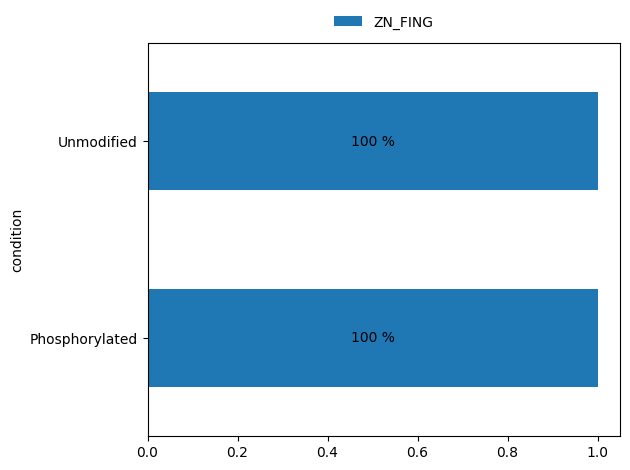

In [282]:
plot_bar_chart(df=pye_r, x_var="condition", y_var="other")

0 other
Not annotated    0.527473
ZN_FING          0.472527
Name: 0, dtype: float64
1 other
Not annotated    0.506256
ZN_FING          0.493744
Name: 1, dtype: float64


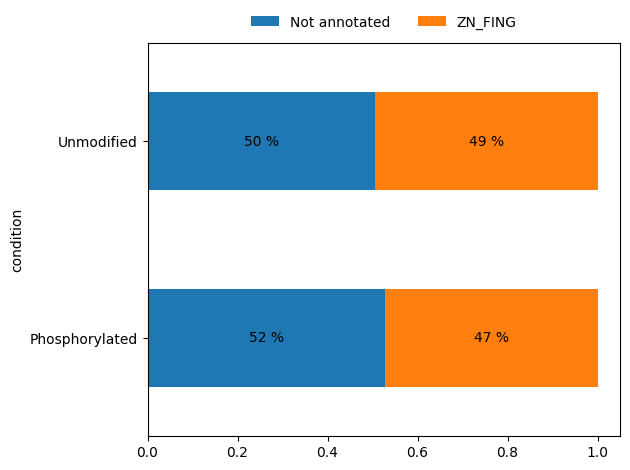

In [275]:
plot_bar_chart(df=df, x_var="condition", y_var="other")

In [268]:
df

,condition,domain,other,DNA_BIND,COILED,ZN_FING
0,Phosphorylated,Not annotated,Not annotated,NaN,NaN,NaN
1,Phosphorylated,Not annotated,Not annotated,NaN,NaN,NaN
2,Phosphorylated,Not annotated,Not annotated,NaN,NaN,NaN
3,Phosphorylated,SH2,SH2,NaN,NaN,NaN
4,Phosphorylated,Not annotated,Not annotated,NaN,NaN,NaN
...,...,...,...,...,...,...
167,Unmodified,Not annotated,Not annotated,NaN,NaN,NaN
168,Unmodified,Not annotated,Not annotated,NaN,NaN,NaN
169,Unmodified,Not annotated,Not annotated,NaN,NaN,NaN
170,Unmodified,MAGE,MAGE,NaN,NaN,NaN


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


0 other
AB hydrolase-1                  NaN
BRICHOS                         NaN
Chorein N-terminal              NaN
Cyclin N-terminal               NaN
DDE-1 1                         NaN
Death                           NaN
Dynamin-type G                  NaN
E2                              NaN
EGF-like                        NaN
FERM                            NaN
Fibronectin type-III 1          NaN
Fibronectin type-III 16         NaN
HTH myb-type 2                  NaN
Helicase C-terminal        0.045455
IF rod                          NaN
IMD                             NaN
Ig-like 3                       NaN
KRAB                            NaN
LIM zinc-binding 1              NaN
MAGE                            NaN
Myb-like                        NaN
Not annotated              0.795455
Orange                          NaN
P/Homo B                        NaN
PH                         0.022727
PH 1                       0.022727
Peptidase M12B             0.022727
Peptidase S1        

posx and posy should be finite values
posx and posy should be finite values


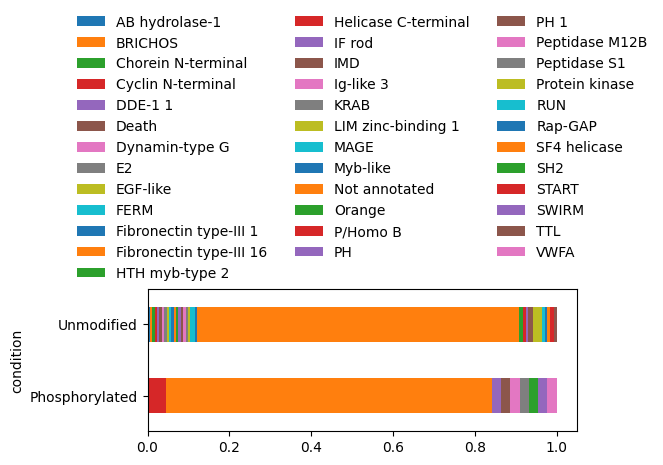

In [267]:
plot_bar_chart(df=df, x_var="condition", y_var="other")

In [229]:
triplet, nn, phosphosite, ref_atom = "PYK", "F", True, "CA"
make_plot(triplet, nn, phosphosite, ref_atom, y_var="domain")
make_plot(triplet, nn, phosphosite, ref_atom, y_var="other")

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/cim/anaconda3/envs/phosphosite/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3505, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_9475/2896569366.py", line 2, in <module>
    make_plot(triplet, nn, phosphosite, ref_atom, y_var="domain")
  File "/tmp/ipykernel_9475/2268225547.py", line 16, in make_plot
    df2 = count_domains(notphos_sites, condition="Unmodified")
  File "/tmp/ipykernel_9475/2537321591.py", line 8, in count_domains
    domain = map_site_to_domain(protein_id=protein_id, pos=pos, multiple=False, condition=condition)
  File "/home/cim/STRUCTURAL_MOTIFS/phosphosite/phosphosite/domain/__init__.py", line 91, in map_site_to_domain
    r = next(r)
StopIteration

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/cim/anaconda3/envs/phosphosite/lib/python3.9/site-packages/IPython/core/interactiveshell.p

In [159]:
map_site_to_domain(protein_id="O43296", pos=343)

([], [], ['Zinc Finger'])

In [ ]:
struct_features = ["ZN_FING", "DOMAIN", "TRANSMEM", "DNA_BIND", "COILED", "ACT_SITE", "BINDING", ]

# INTRAMEM 


In [138]:
protein_id = "A2RRD8" 


In [258]:
triplet, nn, phosphosite, ref_atom = "PYK", "F", True, "CA"
phos_sites = get_sites_from_motif(result_df, triplet, nn, phosphosite=True, ref_atom=ref_atom)
notphos_sites = get_sites_from_motif(result_df, triplet, nn, phosphosite=False, ref_atom=ref_atom)

count_domains(phos_sites)

,other,condition,ZN_FING,domain
0,ZN_FING,None,NaN,NaN
1,NaN,None,True,NaN
2,ZN_FING,None,NaN,NaN
3,NaN,None,True,NaN
4,ZN_FING,None,NaN,NaN
...,...,...,...,...
131,ZN_FING,None,NaN,NaN
132,NaN,None,True,NaN
133,ZN_FING,None,NaN,NaN
134,NaN,None,True,NaN


In [173]:
triplet, nn, phosphosite, ref_atom = "PYE", "R", False, "oxygen"
phos_sites = get_sites_from_motif(result_df, triplet, nn, phosphosite=phosphosite, ref_atom=ref_atom)

count_domains(phos_sites)

([], [], [])
([], [], ['Zinc Finger'])
([], [], ['Zinc Finger'])
([], [], ['Zinc Finger'])
([], [], ['Zinc Finger'])
([], [], ['Zinc Finger'])
([], [], ['Zinc Finger'])
([], [], ['Zinc Finger'])
([], [], ['Zinc Finger'])
([], [], ['Zinc Finger'])
([], [], ['Zinc Finger'])
([], [], ['Zinc Finger'])
([], [], ['Zinc Finger'])
([], [], ['Zinc Finger'])
([], [], ['Zinc Finger'])
([], [], ['Zinc Finger'])
([], [], ['Zinc Finger'])
([], [], ['Zinc Finger'])
([], [], ['Zinc Finger'])
([], [], ['Zinc Finger'])
([], [], ['Zinc Finger'])
([], [], ['Zinc Finger'])
([], [], ['Zinc Finger'])
([], [], ['Zinc Finger'])
([], [], ['Zinc Finger'])
([], [], [])
([], [], ['Zinc Finger'])
([], [], ['Zinc Finger'])
([], [], ['Zinc Finger'])
([], [], [])
([], [], ['Zinc Finger'])
([], [], ['Zinc Finger'])
([], [], ['Zinc Finger'])
([], [], [])
([], [], ['Zinc Finger'])
([], ['Mediates interaction with KHDRBS1', 'Mediates interaction with RELA', 'Mediates interaction with SMAD4'], ['Zinc Finger'])
([], ['Media

{}

In [175]:
triplet, nn, phosphosite, ref_atom = "RYL", "E", False, "oxygen"
phos_sites = get_sites_from_motif(result_df, triplet, nn, phosphosite=phosphosite, ref_atom=ref_atom)

count_domains(phos_sites)

([], [], [])
([], [], [])
([], [], [])
([], [], [])
([], ['Required for response to orexin-A'], [])
(['BRICHOS'], [], [])
([], ['6-phosphofructo-2-kinase'], [])
([], [], [])
(['Protein kinase'], [], [])
([], [], [])


TypeError: '>=' not supported between instances of 'int' and 'UnknownPosition'

In [207]:
pid = "P05165"
pos = 406

# Result df filtered 
df = result_df[(result_df.protein_id == pid) & (result_df.pos == pos)]
df

,protein_id,prev,res,pos,next,ref_atom,ref_atom_dist,nn_res,nn_pos,nn_atom,site_qual,site_structure,nn_qual,nn_structure,phos
0,P05165,P,Y,406,K,CA,3.813011,F,512,O,90.44,TURN_TY1_P,93.93,unstructured,True
1,P05165,P,Y,406,K,OH,3.608106,A,483,CB,90.44,TURN_TY1_P,97.03,HELX_RH_AL_P,True


In [209]:
triplet, nn, phosphosite, ref_atom = "PYE", "R", False, "oxygen"
phos_sites = get_sites_from_motif(result_df, triplet, nn, phosphosite=phosphosite, ref_atom=ref_atom)

count_domains(phos_sites)

,domain,region,other,condition
0,None,None,None,None
1,None,None,Zinc Finger,None
2,None,None,Zinc Finger,None
3,None,None,Zinc Finger,None
4,None,None,Zinc Finger,None
...,...,...,...,...
714,None,None,Zinc Finger,None
715,None,None,Zinc Finger,None
716,None,None,Zinc Finger,None
717,None,None,Zinc Finger,None


In [210]:
triplet, nn, phosphosite, ref_atom = "PYE", "R", True, "oxygen"
pye = get_sites_from_motif(result_df, triplet, nn, phosphosite=True, ref_atom=ref_atom)
[i[0] for i in pye]
pye

[('O43296', 'Y', 343),
 ('O43296', 'Y', 511),
 ('P10586', 'Y', 1676),
 ('P17014', 'Y', 353),
 ('P17028', 'Y', 335),
 ('P17098', 'Y', 341),
 ('P23468', 'Y', 1681),
 ('P43405', 'Y', 323),
 ('P45381', 'Y', 88),
 ('P49910', 'Y', 456),
 ('P51523', 'Y', 599),
 ('Q0VAM2', 'Y', 77),
 ('Q13332', 'Y', 1717),
 ('Q13398', 'Y', 341),
 ('Q14587', 'Y', 584),
 ('Q14592', 'Y', 476),
 ('Q15072', 'Y', 184),
 ('Q6P280', 'Y', 478),
 ('Q6V9R5', 'Y', 400),
 ('Q8NEP9', 'Y', 424),
 ('Q9Y6Q3', 'Y', 405),
 ('Q9H1C4', 'Y', 585),
 ('Q8NCG5', 'Y', 340),
 ('Q8IWX8', 'Y', 894),
 ('Q969J2', 'Y', 348),
 ('Q9C0F3', 'Y', 418),
 ('Q8N988', 'Y', 397),
 ('Q8WUA4', 'Y', 647),
 ('Q9BS34', 'Y', 281),
 ('Q9H7R0', 'Y', 516),
 ('Q9NRF8', 'Y', 53),
 ('Q8NB50', 'Y', 673),
 ('Q8NDT2', 'Y', 611),
 ('Q8N587', 'Y', 337),
 ('Q8N587', 'Y', 393),
 ('Q7Z340', 'Y', 643),
 ('Q8NDQ6', 'Y', 327),
 ('Q8TC21', 'Y', 335),
 ('Q86YZ3', 'Y', 1274)]

In [144]:
pye

[('O43296', 'Y', 343),
 ('O43296', 'Y', 511),
 ('P10586', 'Y', 1676),
 ('P17014', 'Y', 353),
 ('P17028', 'Y', 335),
 ('P17098', 'Y', 341),
 ('P23468', 'Y', 1681),
 ('P43405', 'Y', 323),
 ('P45381', 'Y', 88),
 ('P49910', 'Y', 456),
 ('P51523', 'Y', 599),
 ('Q0VAM2', 'Y', 77),
 ('Q13332', 'Y', 1717),
 ('Q13398', 'Y', 341),
 ('Q14587', 'Y', 584),
 ('Q14592', 'Y', 476),
 ('Q15072', 'Y', 184),
 ('Q6P280', 'Y', 478),
 ('Q6V9R5', 'Y', 400),
 ('Q8NEP9', 'Y', 424),
 ('Q9Y6Q3', 'Y', 405),
 ('Q9H1C4', 'Y', 585),
 ('Q8NCG5', 'Y', 340),
 ('Q8IWX8', 'Y', 894),
 ('Q969J2', 'Y', 348),
 ('Q9C0F3', 'Y', 418),
 ('Q8N988', 'Y', 397),
 ('Q8WUA4', 'Y', 647),
 ('Q9BS34', 'Y', 281),
 ('Q9H7R0', 'Y', 516),
 ('Q9NRF8', 'Y', 53),
 ('Q8NB50', 'Y', 673),
 ('Q8NDT2', 'Y', 611),
 ('Q8N587', 'Y', 337),
 ('Q8N587', 'Y', 393),
 ('Q7Z340', 'Y', 643),
 ('Q8NDQ6', 'Y', 327),
 ('Q8TC21', 'Y', 335),
 ('Q86YZ3', 'Y', 1274)]

In [143]:
print("\n".join([i[0] for i in pye]))

O43296
O43296
P10586
P17014
P17028
P17098
P23468
P43405
P45381
P49910
P51523
Q0VAM2
Q13332
Q13398
Q14587
Q14592
Q15072
Q6P280
Q6V9R5
Q8NEP9
Q9Y6Q3
Q9H1C4
Q8NCG5
Q8IWX8
Q969J2
Q9C0F3
Q8N988
Q8WUA4
Q9BS34
Q9H7R0
Q9NRF8
Q8NB50
Q8NDT2
Q8N587
Q8N587
Q7Z340
Q8NDQ6
Q8TC21
Q86YZ3


In [140]:
phos_sites

[('A2RRD8', 'Y', 189),
 ('A6NN14', 'Y', 544),
 ('A6NNF4', 'Y', 257),
 ('A8MTY0', 'Y', 338),
 ('P05165', 'Y', 406),
 ('P0CJ79', 'Y', 578),
 ('P17022', 'Y', 520),
 ('P17035', 'Y', 327),
 ('P17038', 'Y', 706),
 ('P17040', 'Y', 710),
 ('P17098', 'Y', 313),
 ('Q02386', 'Y', 640),
 ('Q05481', 'Y', 378),
 ('Q05481', 'Y', 686),
 ('Q08AN1', 'Y', 297),
 ('Q08ER8', 'Y', 283),
 ('Q09FC8', 'Y', 404),
 ('Q14160', 'Y', 751),
 ('Q14584', 'Y', 352),
 ('Q14586', 'Y', 408),
 ('Q14586', 'Y', 688),
 ('Q15937', 'Y', 333),
 ('Q15937', 'Y', 389),
 ('Q16600', 'Y', 291),
 ('Q5CZA5', 'Y', 287),
 ('Q5JVG8', 'Y', 341),
 ('Q6ZN19', 'Y', 285),
 ('Q6ZN19', 'Y', 649),
 ('Q6ZNA1', 'Y', 414),
 ('Q6ZNA1', 'Y', 778),
 ('Q6ZR52', 'Y', 137),
 ('Q6ZR52', 'Y', 613),
 ('Q8NCK3', 'Y', 242),
 ('Q8IWY8', 'Y', 706),
 ('Q9UL36', 'Y', 995),
 ('Q8NEP9', 'Y', 284),
 ('Q8N4W9', 'Y', 315),
 ('Q8N4W9', 'Y', 735),
 ('Q8N4W9', 'Y', 819),
 ('Q9H7R5', 'Y', 346),
 ('Q9H7R5', 'Y', 542),
 ('Q76KX8', 'Y', 479),
 ('Q96SE7', 'Y', 261),
 ('Q96SE7',

In [ ]:
count_domains(phos_sites)

In [102]:
d = map_site_to_domain(protein_id="P55265", pos=520)
d

(['DRBM 1'], [])

In [103]:
sites = {}
not_sites = {}



 

NameError: name 'sites' is not defined

TypeError: 'list' object is not callable

In [19]:
len(phos_motif), len(non_motif)

(42, 164)

In [20]:
# Intersection of the two sets
len(set(phos_motif).intersection(set(non_motif)))

2

#### Analysis of uniprot data (protein function / names) of given motif

In [183]:
print("\n".join(phos_motif))

A5YKK6
A6NDG6
A6NFN9
O14544
O14964
O15013
O96014
P00338
P07195
P09172
P09601
P21860
P35580
P52888
P55265
P58753
P62258
Q13459
Q16526
Q16658
Q29983
Q49AN0
Q5VVJ2
Q6P995
Q6UVK1
Q9UKK3
Q9UH17
Q8TC27
Q9Y6V7
Q9UNS1
Q9H4L7
Q8IWA5
Q9NP66
Q96M96
Q8WUR7
Q9Y6A2
Q8N1D5
Q8N960
Q9Y6M0
Q9NT99
Q9GZT6
Q9UPR0


#### Result Dataframe 

In [171]:
result_df

,protein_id,prev,res,pos,next,ref_atom,ref_atom_dist,nn_res,nn_pos,nn_atom,site_qual,site_structure,nn_qual,nn_structure,phosphorylated,phos
0,A0A075B759,N,S,4,V,CA,4.805941,Q,163,NE2,93.22,unstructured,96.92,STRN,0,False
1,A0A075B759,N,S,4,V,OG,3.702720,Q,163,NE2,93.22,unstructured,96.92,STRN,0,False
0,A0A075B759,I,S,21,I,CA,3.452576,V,6,O,98.17,STRN,98.44,STRN,0,False
1,A0A075B759,I,S,21,I,OG,2.965607,E,134,OE2,98.17,STRN,96.86,STRN,0,False
0,A0A075B759,L,S,40,T,CA,3.415834,R,37,O,98.29,HELX_RH_AL_P,98.22,HELX_RH_AL_P,0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,Q9HAU8,M,Y,633,T,OH,2.951282,E,600,OE1,90.56,HELX_RH_AL_P,92.90,HELX_RH_AL_P,0,False
0,Q9HAU8,L,Y,638,E,CA,3.649874,I,635,O,95.74,HELX_RH_AL_P,92.39,HELX_RH_AL_P,0,False
1,Q9HAU8,L,Y,638,E,OH,3.348084,F,654,CA,95.74,HELX_RH_AL_P,96.85,HELX_RH_AL_P,0,False
0,Q9HAU8,F,Y,655,Q,CA,3.484021,Q,658,NE2,96.43,HELX_RH_AL_P,92.47,HELX_RH_3T_P,0,False


In [159]:

#result_df[(result_df.prev == "R") & (result_df.next == "L") & (result_df.nn_res == "E") & (result_df.res == "T") & (result_df.phos == True)]

In [163]:
# All rows with prev == "R" and next == "L" 
result_df[(result_df.prev == "R") & (result_df.next == "L") & (result_df.nn_res == "E") & (result_df.res == "Y") & (result_df.phos == True) & (result_df.protein_id == "P09172")]


,protein_id,prev,res,pos,next,ref_atom,ref_atom_dist,nn_res,nn_pos,nn_atom,site_qual,site_structure,nn_qual,nn_structure,phosphorylated,phos
1,P09172,R,Y,327,L,OH,2.855771,E,236,OE1,95.06,STRN,94.79,STRN,0,True


In [130]:
# Put phos series into new column of result_df
result_df["phos"] 

0    0
1    0
0    0
1    0
0    1
    ..
1    0
0    0
1    0
0    0
1    0
Name: phos, Length: 2574086, dtype: int64

In [135]:
# Annotate with 1 if phosphorylated, 0 otherwise
# i.e. if a row exists in the phosphosite dataframe for the given protein_id, residue and position
result_df["phosphorylated"] = result_df.merge(df, on=["protein_id", "res", "pos"], how="left").modification.notna()#.astype(int)
result_df

KeyError: 'res'

In [122]:
result_df["phosphorylated"].index

Int64Index([0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
            ...
            0, 1, 0, 1, 0, 1, 0, 1, 0, 1],
           dtype='int64', length=2574086)

In [144]:
result_df.phosphorylated.value_counts()

0    2574086
Name: phosphorylated, dtype: int64

In [116]:
#"Q8IYH5"	"S"	606	
# All rows with protein_id Q8IYH5, residue S and position 606
result_df.query("protein_id == 'Q8IYH5' and res == 'S' and pos == 606")

,protein_id,prev,res,pos,next,ref_atom,ref_atom_dist,nn_res,nn_pos,nn_atom,site_qual,site_structure,nn_qual,nn_structure,phosphorylated
0,Q8IYH5,K,S,606,P,CA,5.857166,R,603,NH2,37.24,HELX_LH_PP_P,34.7,HELX_LH_PP_P,0
1,Q8IYH5,K,S,606,P,OG,4.407101,R,603,NH2,37.24,HELX_LH_PP_P,34.7,HELX_LH_PP_P,0


In [134]:
result_df["ref_atom"].unique()

array(['CA', 'OG', 'OG1', 'OH'], dtype=object)

In [74]:
phosphorylation

,GENE,PROTEIN,ACC_ID,HU_CHR_LOC,MOD_RSD,SITE_GRP_ID,ORGANISM,MW_kD,DOMAIN,SITE_+/-7_AA,LT_LIT,MS_LIT,MS_CST,CST_CAT#,Ambiguous_Site
0,0610009B22Rik,0610009B22Rik,Q8R3W2,11|11 B1.3,S119-p,1868286063,mouse,16.44,Sedlin_N,NPFYEPNsPIRSSAF,NaN,1.0,NaN,NaN,1
1,1110035H17Rik,1110035H17Rik,Q9CTA4,7|7,S10-p,7231581,mouse,24.31,NaN,RPPPGSRstVAQSPP,NaN,1.0,NaN,NaN,0
2,1110035H17Rik,1110035H17Rik,Q9CTA4,7|7,T11-p,7231583,mouse,24.31,NaN,PPPGSRstVAQSPPQ,NaN,1.0,NaN,NaN,0
3,YWHAB,14-3-3 beta,P31946,20q13.12,T2-p,15718712,human,28.08,NaN,______MtMDksELV,NaN,3.0,1.0,NaN,0
4,Ywhab,14-3-3 beta,Q9CQV8,2|2 H3,T2-p,15718712,mouse,28.09,NaN,______MtMDksELV,NaN,2.0,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
378766,ZZZ3,ZZZ3,Q8IYH5,1p31.1,S606-p,23077718,human,102.02,NaN,GLPARPksPLDPKKD,NaN,6.0,4.0,NaN,0
378767,Zzz3,ZZZ3,Q6KAQ7,3|3 H3,S613-p,23077718,mouse,102.31,NaN,GLPARPKsPLDPKKD,NaN,3.0,NaN,NaN,0
378768,ZZZ3,ZZZ3,Q8IYH5,1p31.1,Y670-p,23077724,human,102.02,Myb_DNA-binding,LEQLLIKyPPEEVEs,NaN,NaN,1.0,NaN,0
378769,ZZZ3,ZZZ3,Q8IYH5,1p31.1,S677-p,23077721,human,102.02,Myb_DNA-binding,yPPEEVEsRRWQKIA,NaN,NaN,1.0,NaN,0


In [72]:
# Annotate whether site is phosphorylated by checking if it appears in the `phosphorylation` dataframe.
result_df["is_phosphorylated"] = result_df.apply(
    lambda row: row["site"] in df[df["ACC_ID"] == row["protein_id"]]["MOD_RSD"].values, axis=1
)
result_df



KeyError: 'site'

#### Format dataframe for plotting

In [49]:
from phosphosite.load_data import background_df
background_df

Loaded 1626747 rows from 17236 proteins from /home/cim/STRUCTURAL_MOTIFS/phosphosite/data/motif/all-STY-6A2R3N-ca


,phosphosite,site_qual,protein_id,-2,-1,site,+1,+2,1_res,1_euc_dist,1_seq_dist,2_res,2_euc_dist,2_seq_dist,3_res,3_euc_dist,3_seq_dist,site_res
0,False,97.25,A4D161,F55,V56,S57,W58,R59,L68,4.565690,11.0,V168,5.344849,111.0,V69,5.486743,12.0,S
1,False,96.28,A4D161,W58,R59,S60,P61,T62,H165,4.569219,105.0,M64,5.361986,4.0,G63,5.467722,3.0,S
3,False,93.90,A4D161,Q132,H133,S134,A135,A136,F139,5.026949,5.0,T140,5.513947,6.0,NaN,NaN,NaN,S
5,False,91.36,A4D161,K146,C147,S148,G149,F150,T140,4.988242,-8.0,NaN,NaN,NaN,NaN,NaN,NaN,S
6,False,93.82,A4D161,F150,H151,S152,C153,F154,C124,4.395364,-28.0,Y163,5.754202,11.0,R125,5.771420,-27.0,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1626741,False,98.48,Q9Y6Z7,K167,N168,Y169,R170,E171,S172,5.002993,3.0,C262,5.225002,93.0,NaN,NaN,NaN,Y
1626742,False,95.80,Q9Y6Z7,A196,D197,Y198,V199,A200,I195,4.982128,-3.0,K201,5.228723,3.0,NaN,NaN,NaN,Y
1626743,False,96.86,Q9Y6Z7,G218,Q219,Y220,M221,F222,D213,4.266357,-7.0,N212,5.267836,-8.0,L228,5.651411,8.0,Y
1626744,False,94.49,Q9Y6Z7,Q229,N230,Y231,S232,N233,D188,5.904622,-43.0,NaN,NaN,NaN,NaN,NaN,NaN,Y


#### Old background df



In [133]:
from phosphosite.load_data import background_df
background_df

,phosphosite,site_qual,protein_id,-2,-1,site,+1,+2,1_res,1_euc_dist,1_seq_dist,2_res,2_euc_dist,2_seq_dist,3_res,3_euc_dist,3_seq_dist,site_res
0,False,97.25,A4D161,F55,V56,S57,W58,R59,L68,4.565690,11.0,V168,5.344849,111.0,V69,5.486743,12.0,S
1,False,96.28,A4D161,W58,R59,S60,P61,T62,H165,4.569219,105.0,M64,5.361986,4.0,G63,5.467722,3.0,S
3,False,93.90,A4D161,Q132,H133,S134,A135,A136,F139,5.026949,5.0,T140,5.513947,6.0,NaN,NaN,NaN,S
5,False,91.36,A4D161,K146,C147,S148,G149,F150,T140,4.988242,-8.0,NaN,NaN,NaN,NaN,NaN,NaN,S
6,False,93.82,A4D161,F150,H151,S152,C153,F154,C124,4.395364,-28.0,Y163,5.754202,11.0,R125,5.771420,-27.0,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1626741,False,98.48,Q9Y6Z7,K167,N168,Y169,R170,E171,S172,5.002993,3.0,C262,5.225002,93.0,NaN,NaN,NaN,Y
1626742,False,95.80,Q9Y6Z7,A196,D197,Y198,V199,A200,I195,4.982128,-3.0,K201,5.228723,3.0,NaN,NaN,NaN,Y
1626743,False,96.86,Q9Y6Z7,G218,Q219,Y220,M221,F222,D213,4.266357,-7.0,N212,5.267836,-8.0,L228,5.651411,8.0,Y
1626744,False,94.49,Q9Y6Z7,Q229,N230,Y231,S232,N233,D188,5.904622,-43.0,NaN,NaN,NaN,NaN,NaN,NaN,Y
